# Util functions

In [117]:
import os

def get_method_name(log_path: str) -> str:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    file_name_split = file_name.split('_')
    
    if file_name_split[4] == 'EDF':
        method_name = 'EDF'
    else:
        method_name = file_name_split[1]

    return method_name

In [118]:
from typing import Dict

def get_classification(log: Dict) -> str:
    if 'deadline_miss' in log.keys() and 'early_detection' in log.keys():
        classification = 'TP'
    elif 'deadline_miss' not in log.keys() and 'early_detection' in log.keys():
        classification = 'FP'
    elif 'deadline_miss' in log.keys() and 'early_detection' not in log.keys():
        classification = 'FN'
    elif 'deadline_miss' not in log.keys() and 'early_detection' not in log.keys():
        classification = 'TN'

    return classification

## Plot

In [119]:
from typing import Generator
import pandas as pd
import numpy as np

def color_pattern_gen(df: pd.DataFrame) -> Generator:
    patterns = [ "//" , "\\" , "+" , "..", "o", "x", "|" , "-", "O", "*" ]
    colors = [str(round(c, 1)) for c in np.arange(0.2, 1.0, 0.8/len(df))]
    
    for i in range(len(df)):
        yield {'color': colors[i],
               'edgecolor': 'black',
               'linewidth': 1,
               'hatch': patterns[i % len(df)]}

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def stack_bar_plot(
    df: pd.DataFrame,
    xlabel: str = '',
    save_name: str = ''
) -> None:
    cp_gen = color_pattern_gen(df)
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(df)):
        ax.bar(df.columns,
                df.iloc[i], 
                bottom=df.iloc[:i].sum(),
                width=0.6,
                **next(cp_gen)
                )
    ax.set_xlabel(xlabel=xlabel, fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(df.index, fontsize=14, loc='upper left')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

In [121]:
from matplotlib.colors import ListedColormap

def line_plot(
    df: pd.DataFrame,
    xlabel: str = '',
    ylabel: str = '',
    save_name: str = ''
) -> None:
    colors = [str(round(c, 1)) for c in np.arange(0, 0.6, 0.6/len(df))]
    cmap = ListedColormap(colors, name="custom")
    fig, ax = plt.subplots()
    df.plot(ax=ax,
            figsize=(10, 8),
            colormap=cmap,
            style=['s--', 's:', 's-.', 's-'],
            linewidth=2,
            markersize=6,
            markeredgewidth=2,
            grid=True,
            fontsize=14)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=14, loc='upper left')
    
    if save_name:
        plt.savefig(f'./results/figures/{save_name}')
    
    plt.show()

# Total utilization varied

In [122]:
def get_utilization(log_path: str) -> float:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    utilization_str = file_name.split('_')[-1]
    utilization = float(utilization_str.split('=')[1])

    if 0.60 <= utilization < 0.65:
        utilization = 60
    elif 0.65 <= utilization < 0.7:
        utilization = 65
    elif 0.7 <= utilization < 0.75:
        utilization = 70
    elif 0.75 <= utilization < 0.8:
        utilization = 75
    elif 0.8 <= utilization < 0.85:
        utilization = 80
    elif 0.85 <= utilization < 0.9:
        utilization = 85
    elif 0.9 <= utilization < 1.0:
        utilization = 90

    return utilization


In [123]:
import glob
import pandas as pd
import yaml
import numpy as np

METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']
UTILIZATION_VALUES = [str(round(c, 0)) for c in np.arange(60, 95, 5)]

utilization_df_dict = {}
for method in METHOD_NAMES:
    utilization_df_dict[method] = pd.DataFrame(index=['TP', 'FN', 'TN', 'FP'],
                                               columns=UTILIZATION_VALUES)
    utilization_df_dict[method].fillna(0, inplace=True)

In [124]:
log_paths = glob.glob("./results/utilization_varied/*.yaml")

for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)
    
    method_name = get_method_name(log_path)
    utilization = get_utilization(log_path)
    classification = get_classification(log)
    utilization_df_dict[method_name].at[str(classification), str(utilization)] += 1

## Precision

In [126]:
precision_df = pd.DataFrame(index=METHOD_NAMES,
                            columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    precision_df.loc[method] = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FP'])

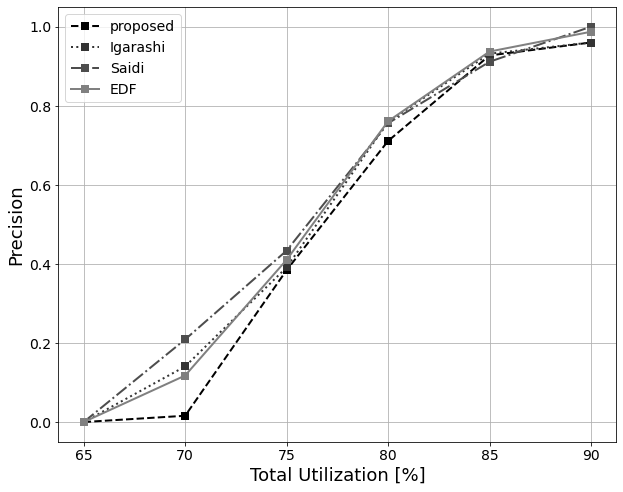

In [127]:
precision_df = precision_df.T
line_plot(precision_df, 'Total Utilization [%]', 'Precision', 'line_plot_precision.pdf')

# Recall

In [128]:
recall_df = pd.DataFrame(index=METHOD_NAMES,
                            columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    recall_df.loc[method] = utilization_df_dict[method].loc['TP'] / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['FN'])

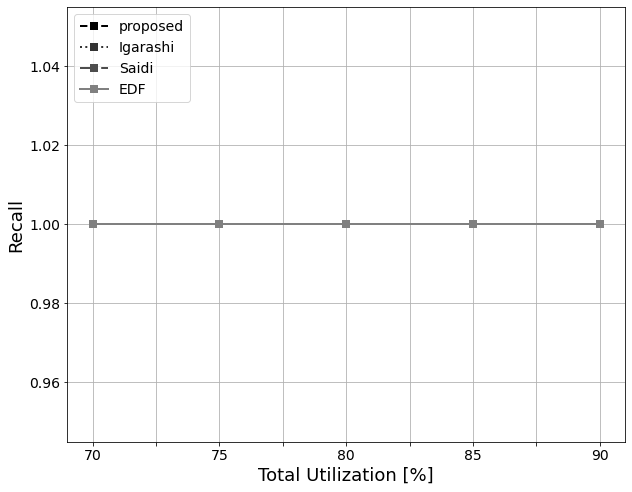

In [129]:
recall_df = recall_df.T
line_plot(recall_df, 'Total Utilization [%]', 'Recall', 'line_plot_recall.pdf')

# Specificity

In [130]:
specificity_df = pd.DataFrame(index=METHOD_NAMES,
                         columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    specificity_df.loc[method] = utilization_df_dict[method].loc['TN'] / (utilization_df_dict[method].loc['TN'] + utilization_df_dict[method].loc['FP'])

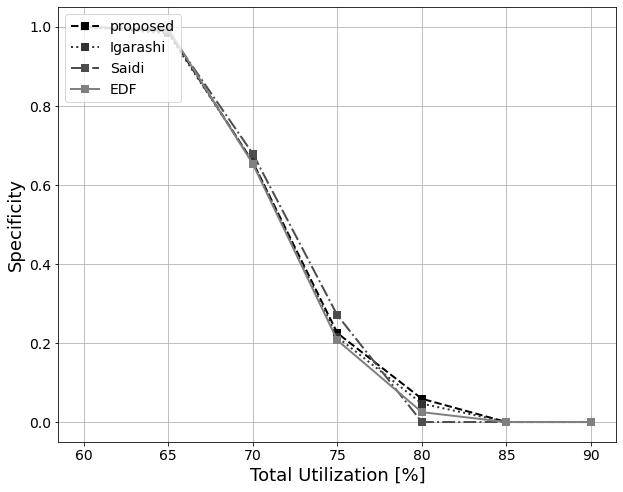

In [131]:
specificity_df = specificity_df.T
line_plot(specificity_df, 'Total Utilization [%]', 'Specificity', 'line_plot_specificity.pdf')

# Accuracy

In [132]:
accuracy_df = pd.DataFrame(index=METHOD_NAMES,
                              columns=UTILIZATION_VALUES)

for method in METHOD_NAMES:
    accuracy_df.loc[method] = ((utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['TN'])
                                  / (utilization_df_dict[method].loc['TP'] + utilization_df_dict[method].loc['TN'] + utilization_df_dict[method].loc['FP'] + utilization_df_dict[method].loc['FN']))

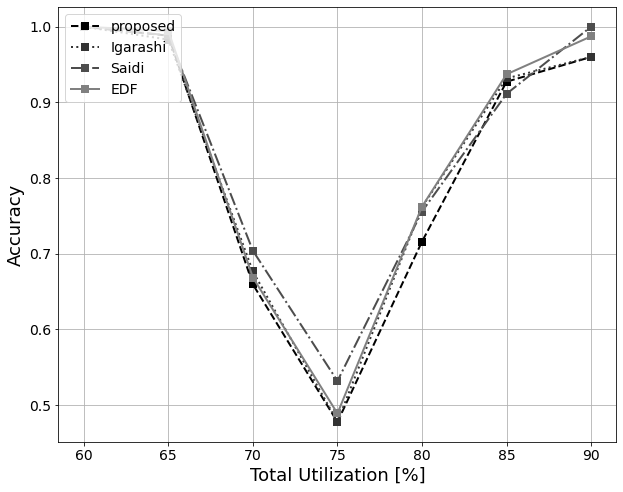

In [133]:
accuracy_df = accuracy_df.T
line_plot(accuracy_df, 'Total Utilization [%]', 'Accuracy', 'line_plot_accuracy.pdf')

## Four ratio

In [134]:
for method in METHOD_NAMES:
    utilization_df_dict[method] = \
        utilization_df_dict[method].div(utilization_df_dict[method].sum(axis=0), axis=1)
    utilization_df_dict[method].rename(index={'TP': 'TP Ratio', 'FN': 'FN Ratio', 'TN': 'TN Ratio', 'FP': 'FP Ratio'})

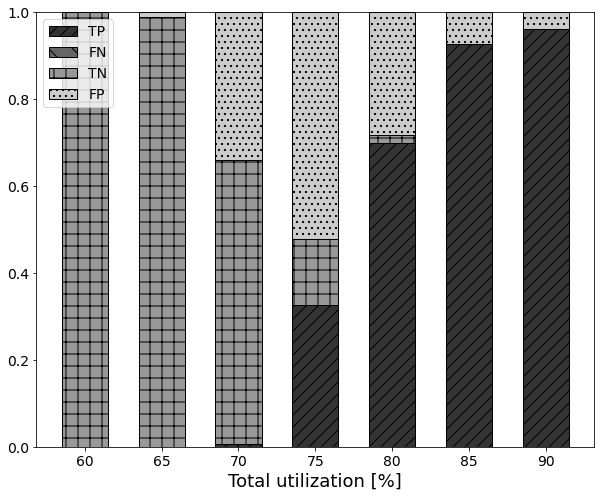

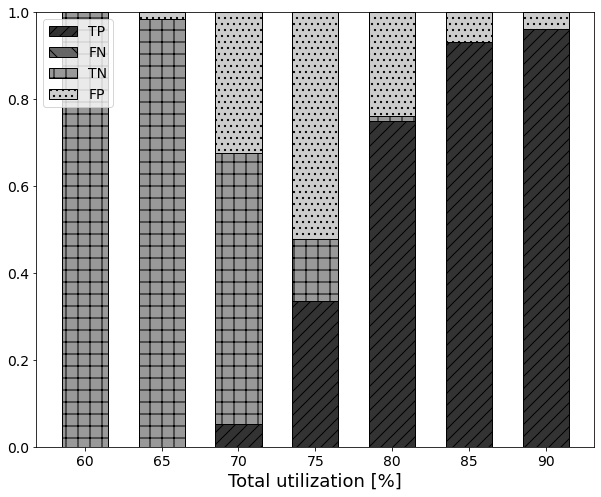

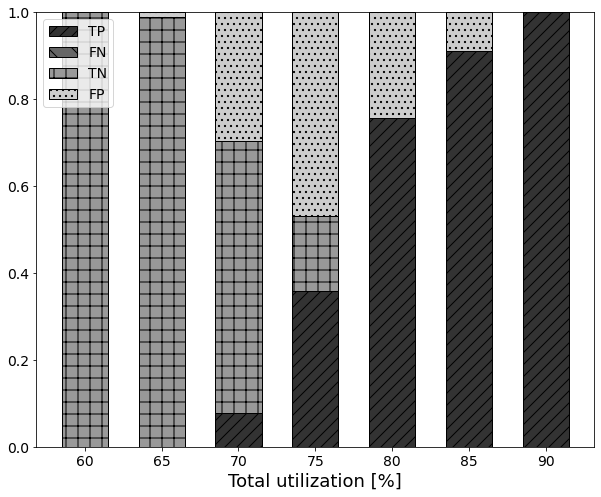

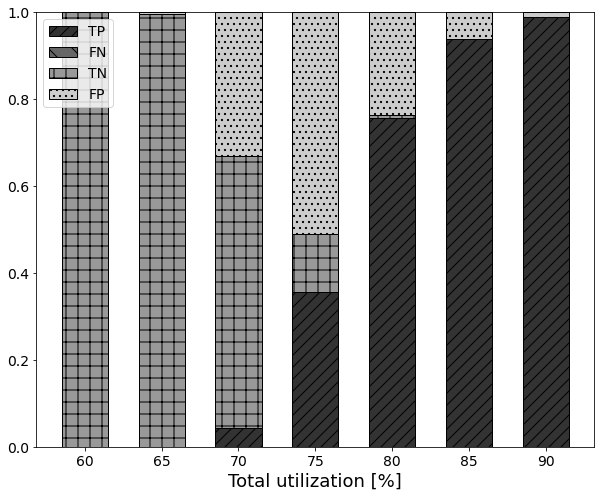

In [135]:
for method in METHOD_NAMES:
    stack_bar_plot(utilization_df_dict[method], 
                   xlabel='Total utilization [%]',
                   save_name=f'stack_bar_four_ratio_{method}.pdf')

# Earlier time

In [136]:
earlier_time_dict = {'proposed': [],
                     'Igarashi': [],
                     'Saidi': [],
                     'EDF': []}

log_paths = glob.glob("./results/utilization_varied/*.yaml") + glob.glob("./results/alpha_varied/*.yaml")
for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)

    if get_classification(log) == 'TP':
        earlier_time = (log['deadline_miss']['deadline_miss_time']
                        - log['early_detection']['detection_time'])
        earlier_time_dict[get_method_name(log_path)].append(earlier_time)

In [137]:
METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']

for method in METHOD_NAMES:
    print(f'{method} ave: {sum(earlier_time_dict[method])/len(earlier_time_dict[method])}')
    print(f'{method} max: {max(earlier_time_dict[method])}')

proposed ave: 549005.0711382114
proposed max: 599633
Igarashi ave: 551316.0361445784
Igarashi max: 599584
Saidi ave: 552089.1066799602
Saidi max: 599960
EDF ave: 548616.8996062992
EDF max: 599353


# Alpha varied

In [138]:
def get_alpha(log_path: str) -> float:
    file_name = os.path.splitext(os.path.basename(log_path))[0]
    alpha_str = file_name.split('_')[2]
    alpha = float(alpha_str.split('=')[1])

    return round(alpha, 1)

In [139]:
import glob
import pandas as pd
import yaml
import numpy as np

METHOD_NAMES = ['proposed', 'Igarashi', 'Saidi', 'EDF']

alpha_df_dict = {}
for method in METHOD_NAMES:
    alpha_df_dict[method] = pd.DataFrame(index=['TP Ratio', 'FN Ratio', 'TN Ratio', 'FP Ratio'],
                                         columns=[str(round(c, 1)) for c in np.arange(1.4, 2.0, 0.1)])
    alpha_df_dict[method].fillna(0, inplace=True)

In [140]:
log_paths = glob.glob("./results/alpha_varied/*.yaml")

for log_path in log_paths:
    with open(log_path, "r") as f:
        log = yaml.safe_load(f)
    
    method_name = get_method_name(log_path)
    alpha = get_alpha(log_path)
    classification = get_classification(log)
    alpha_df_dict[method_name].at[f'{classification} Ratio', str(round(alpha, 1))] += 1

In [141]:
alpha_df_dict['proposed']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,49,95,93,101,102,95,47
FN Ratio,0,0,0,0,0,0,0
TN Ratio,6,11,10,8,8,11,5
FP Ratio,29,61,63,58,57,60,32


In [142]:
alpha_df_dict['Igarashi']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,53,92,89,97,99,98,47
FN Ratio,0,0,0,0,0,0,0
TN Ratio,2,4,6,8,7,3,5
FP Ratio,29,71,71,62,61,65,32


In [143]:
alpha_df_dict['Saidi']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,52,94,94,93,97,101,45
FN Ratio,0,0,0,0,0,0,0
TN Ratio,3,6,8,2,8,9,1
FP Ratio,29,67,64,72,62,56,38


In [144]:
alpha_df_dict['EDF']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,47,105,100,102,102,87,51
FN Ratio,0,0,0,0,0,0,0
TN Ratio,4,7,3,7,7,7,5
FP Ratio,33,55,63,58,58,72,28


In [145]:
for method in METHOD_NAMES:
    alpha_df_dict[method] = \
        alpha_df_dict[method].div(alpha_df_dict[method].sum(axis=0), axis=1)

In [146]:
alpha_df_dict['proposed']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,0.583333,0.568862,0.560241,0.604790,0.610778,0.572289,0.559524
FN Ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TN Ratio,0.071429,0.065868,0.060241,0.047904,0.047904,0.066265,0.059524
FP Ratio,0.345238,0.365269,0.379518,0.347305,0.341317,0.361446,0.380952


In [147]:
alpha_df_dict['Igarashi']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,0.630952,0.550898,0.536145,0.580838,0.592814,0.590361,0.559524
FN Ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TN Ratio,0.023810,0.023952,0.036145,0.047904,0.041916,0.018072,0.059524
FP Ratio,0.345238,0.425150,0.427711,0.371257,0.365269,0.391566,0.380952


In [148]:
alpha_df_dict['Saidi']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,0.619048,0.562874,0.566265,0.556886,0.580838,0.608434,0.535714
FN Ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TN Ratio,0.035714,0.035928,0.048193,0.011976,0.047904,0.054217,0.011905
FP Ratio,0.345238,0.401198,0.385542,0.431138,0.371257,0.337349,0.452381


In [149]:
alpha_df_dict['EDF']

,1.4,1.5,1.6,1.7,1.8,1.9,2.0
TP Ratio,0.559524,0.628743,0.602410,0.610778,0.610778,0.524096,0.607143
FN Ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TN Ratio,0.047619,0.041916,0.018072,0.041916,0.041916,0.042169,0.059524
FP Ratio,0.392857,0.329341,0.379518,0.347305,0.347305,0.433735,0.333333
